In [190]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.optimize import curve_fit
import uncertainties as unc
from sympy.abc import *

In [191]:
def get_measurementData(filename, MEASUREMENT_FIRST_VALID_INDEX, MEASUREMENT_LAST_VALID_INDEX):
    df = pd.read_csv(filename, header=None)
    t = df.iloc[MEASUREMENT_FIRST_VALID_INDEX:MEASUREMENT_LAST_VALID_INDEX, 3].to_numpy().astype(float)
    x = df.iloc[MEASUREMENT_FIRST_VALID_INDEX:MEASUREMENT_LAST_VALID_INDEX, 5].to_numpy().astype(float)
    v = df.iloc[MEASUREMENT_FIRST_VALID_INDEX:MEASUREMENT_LAST_VALID_INDEX, 7].to_numpy().astype(float)
    a = df.iloc[MEASUREMENT_FIRST_VALID_INDEX:MEASUREMENT_LAST_VALID_INDEX, 9].to_numpy().astype(float)
    return t, x, v, a


number_of_intervals=4
filename = './final_data/run1_height_4.csv'
MEASUREMENT_FIRST_VALID_INDEX = 130
MEASUREMENT_LAST_VALID_INDEX = 270

t, x, v, a = get_measurementData(
    filename, 
    MEASUREMENT_FIRST_VALID_INDEX, 
    MEASUREMENT_LAST_VALID_INDEX)

a_mean = np.mean(a) # we want a to be constant always, therefore we take the mean from the whole population

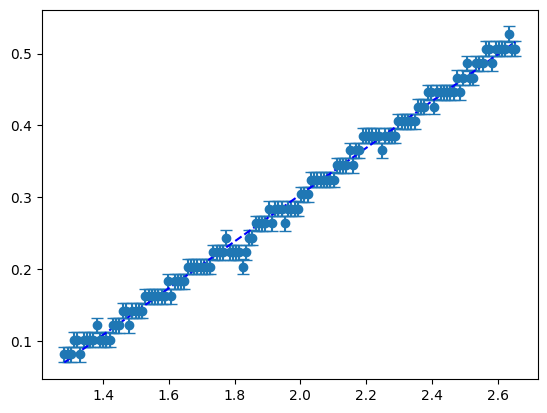

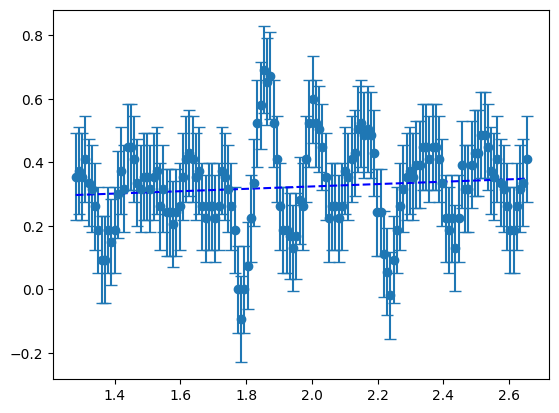

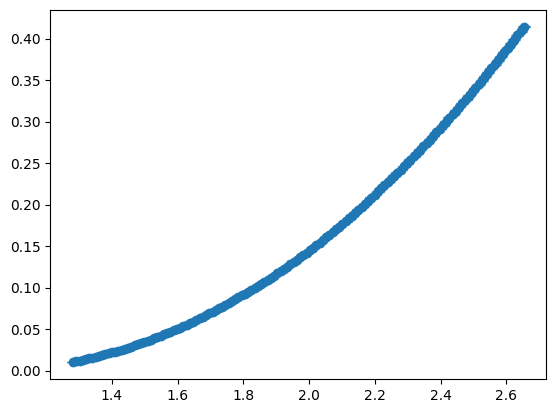

In [192]:
def getErrors(t, x, v, a):
    def plot_measurement_error(x, y, dy, f, *f_params_args):
        plt.figure()
        plt.errorbar(x,y,yerr=dy,fmt='o',capsize=4)
        t_values = np.linspace(t[0],t[-1],100)
        plt.plot(t_values,f(t_values, *f_params_args),'b--')
        plt.show()
    
    def f_linear(x,A,B):
        return A+B*x
        
    def f_parabolic(x,A,B,C):
        return A+B*x+C*x**2

    # calculate errors and plot them
    # v by t    
    param,cov = curve_fit(f_linear,t, v)
    A = param[0]
    B = param[1]
    dv = np.std(v-f_linear(t, A, B),ddof=2)
    plot_measurement_error(t, v, dv, f_linear, A, B)

    # a by t
    param,cov = curve_fit(f_linear,t, a)
    A = param[0]
    B = param[1]
    da = np.std(a-f_linear(t, A, B),ddof=2)
    plot_measurement_error(t, a, da, f_linear, A, B)

    # x by t
    param,cov = curve_fit(f_parabolic,t, x)
    A = param[0]
    B = param[1]
    C = param[2]
    dx = np.std(x-f_parabolic(t, A, B, C),ddof=3)
    plot_measurement_error(t, x, dx, f_parabolic, A, B, C)


    return dv, da,dx

dv, da, dx = getErrors(t, x, v, a)

In [193]:
total_points = len(t)
points_per_interval = total_points // number_of_intervals
# Create n separate intervals
t_intervals = [t[i * points_per_interval: (i + 1) * points_per_interval] for i in range(number_of_intervals)]
x_intervals = [x[i * points_per_interval: (i + 1) * points_per_interval] for i in range(number_of_intervals)]
v_intervals = [v[i * points_per_interval: (i + 1) * points_per_interval] for i in range(number_of_intervals)]
a_intervals = [a[i * points_per_interval: (i + 1) * points_per_interval] for i in range(number_of_intervals)] 

In [202]:
def calculate_pi_1(x, v, t):
    return (x[-1]-x[0]) / (v[0] * (t[-1]-t[0]))

def calculate_pi_2(a_mean, v, t):
    return a_mean * (t[-1]-t[0]) / v[0]

def plot_regression_with_errors():
    pi_1 = []
    pi_2 = []
    for i in range(number_of_intervals):
        t_interval = t_intervals[i]
        x_interval = x_intervals[i]
        v_interval = v_intervals[i]

        t_initial_error = unc.ufloat(t[0], 0)
        t_final_error = unc.ufloat(t[-1], 0)
        x_initial_error = unc.ufloat(x[0], dx)
        x_final_error = unc.ufloat(x[-1], dx)
        v_initial_error = unc.ufloat(v[0], dv)
        x_interval_with_error = [x_initial_error, x_final_error]
        t_interval_with_error = [t_initial_error, t_final_error]
        v_interval_with_error = [v_initial_error]

        pi_1.append(calculate_pi_1(x_interval_with_error, v_interval_with_error, t_interval_with_error))
        pi_2.append(calculate_pi_2(a_mean, v_interval_with_error, t_interval_with_error))
    def f(x,A,B):
        return A+B*x
    param,cov = curve_fit(f,pi_2,pi_1)
    A = unc.ufloat(param[0],np.sqrt(np.diag(cov))[0])
    B = unc.ufloat(param[1],np.sqrt(np.diag(cov))[1])
    print('A = {}'.format(A))
    print('B = {}'.format(B))

    plt.figure()
    pi2_values = np.linspace(min(pi_2),max(pi_2),100)
    plt.plot(pi_2,pi_1,'b+')
    plt.plot(pi2_values, f(pi2_values, *param),'b--')
    plt.show()

def error_propagara_from_AB_to_pis(A, B):
    pass


plot_regression_with_errors()

[3.629493998794873+/-0.4694401586450786, 3.629493998794873+/-0.4694401586450786, 3.629493998794873+/-0.4694401586450786, 3.629493998794873+/-0.4694401586450786]
[5.460718569349546+/-0.7062190031584565, 5.460718569349546+/-0.7062190031584565, 5.460718569349546+/-0.7062190031584565, 5.460718569349546+/-0.7062190031584565]


TypeError: can't convert an affine function (<class 'uncertainties.core.AffineScalarFunc'>) to float; use x.nominal_value